<a href="https://colab.research.google.com/github/Kasturesakshi/portfolio/blob/main/ECommerce_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-commerce Product recommendation System

##Importing libraries

In [44]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

## Importing Dataset

In [2]:
#Import the data set
df = pd.read_csv('ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

### Shape

In [3]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  257882
No of columns =  3


### Datatypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257882 entries, 0 to 257881
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  257882 non-null  object 
 1   prod_id  257882 non-null  object 
 2   rating   257881 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.9+ MB


### Missing value analysis

In [5]:
# Find number of missing values in each column
df.isna().sum()

,0
user_id,0
prod_id,0
rating,1


### Summary

In [6]:
# Summary statistics of 'rating' variable
df['rating'].describe()

,rating
count,257881.000000
mean,3.991942
std,1.387698
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


### Rating distribution

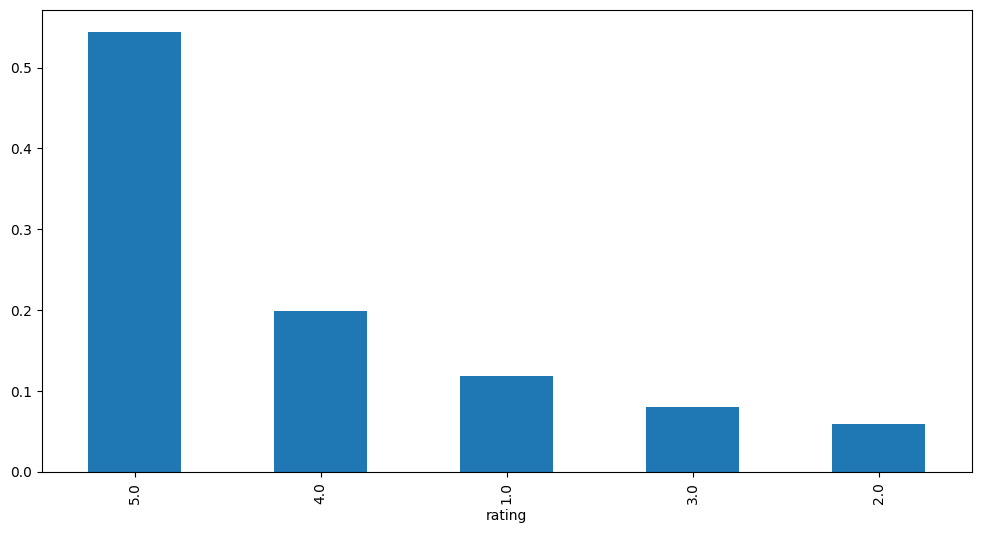

In [7]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [8]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  219906
Number of unique ITEMS in Raw data =  16027


### Users with most no of rating

In [9]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

,0
user_id,
A231WM2Z2JL0U3,222
A5JLAU2ARJ0BO,149
A25HBO5V8S8SEA,100
A2AEZQ3DGBBLPR,61
A6FIAB28IS79,57
AT2J7H5TRZM8Z,57
A1MJMYLRTZ76ZX,54
A2BGZ52M908MJY,54
A12DLJESJKM1OQ,53


## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [10]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [11]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 807
Number of unique USERS in the final data =  9
Number of unique PRODUCTS in the final data =  709


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [12]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (9, 709)
given_num_of_ratings =  807
possible_num_of_ratings =  6381
density: 12.65%


prod_id,1400532655,B000000O48,B00000J05A,B00000J1E6,B00000J1UQ,B00000J1US,B00000J3NG,B00000J434,B00000J49I,B00000J4CY,...,B00008RHA3,B00008RUXS,B00008RW87,B00008RW8V,B00008SB1D,B00008VFCS,B00008VFCT,B00008W2LR,B00008W7LK,B00008W7LL
user_id,,,,,,,,,,,,,,,,,,,,,
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0
A25HBO5V8S8SEA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
A2AEZQ3DGBBLPR,0.0,5.0,0.0,1.0,0.0,0.0,5.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Rank Based Recommendation System

In [16]:
 #Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B00008W7LK,5.0,1
B00008W2LR,5.0,1
B000000O48,5.0,1
B00008IP4V,5.0,1
B00008IP4W,5.0,1


In [14]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

## Recommending top 5 products with 50 minimum interactions based on popularity

In [17]:
list(top_n_products(final_rating, 5, 50))

[]

## Recommending top 5 products with 100 minimum interactions based on popularity

In [18]:
list(top_n_products(final_rating, 5, 100))

[]

# Collaborative Filtering based Recommendation System

## User based collaborative filtering

In [19]:
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B00000J05A,B00000J1E6,B00000J1UQ,B00000J1US,B00000J3NG,B00000J434,B00000J49I,B00000J4CY,...,B00008RHA3,B00008RUXS,B00008RW87,B00008RW8V,B00008SB1D,B00008VFCS,B00008VFCT,B00008W2LR,B00008W7LK,B00008W7LL
user_id,,,,,,,,,,,,,,,,,,,,,
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0
A25HBO5V8S8SEA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
A2AEZQ3DGBBLPR,0.0,5.0,0.0,1.0,0.0,0.0,5.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [20]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B00000J05A,B00000J1E6,B00000J1UQ,B00000J1US,B00000J3NG,B00000J434,B00000J49I,B00000J4CY,...,B00008RHA3,B00008RUXS,B00008RW87,B00008RW8V,B00008SB1D,B00008VFCS,B00008VFCT,B00008W2LR,B00008W7LK,B00008W7LL
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
4,0.0,5.0,0.0,1.0,0.0,0.0,5.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function to find Similar users and their similarity scores

In [21]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

#### Finding out top 10 similar users to the user index 3 and their similarity score

In [22]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[2, 7, 6, 1, 5, 0, 4, 8]

In [23]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.04701735]]),
 array([[0.0161302]]),
 array([[0.01303565]]),
 array([[0.01151454]]),
 array([[0.00982106]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]])]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

In [42]:
similar = similar_users(6, final_ratings_matrix)[0][0:10]
similar

[2, 0, 8, 4, 7, 3, 1, 5]

In [41]:
#Print the similarity score
similar_users(6,final_ratings_matrix)[1][0:10]

[array([[0.09018273]]),
 array([[0.0738359]]),
 array([[0.06065416]]),
 array([[0.03278142]]),
 array([[0.01906298]]),
 array([[0.01303565]]),
 array([[0.0079735]]),
 array([[0.]])]

### Function to recommend products

In [40]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [45]:
recommendations(3,5,final_ratings_matrix)

['B00005B70I', 'B000023VUL', 'B00005AYLL', 'B00004YMBK', 'B00005R8TR']

#### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [47]:
recommendations(6,5,final_ratings_matrix)

['B00005B70I', 'B000023VUL', 'B00005AYLL', 'B00004YMBK', 'B00005R8TR']

# Model based Collaborative Filtering: Singular Value Decomposition

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

## CSR matrix

In [48]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


## SVD

In [50]:
 # Singular Value Decomposition
k = min(50, min(final_ratings_sparse.shape) - 1)  # Ensure k is within the allowed range
U, s, Vt = svds(final_ratings_sparse, k=k)  # Now use the adjusted k value

# Construct diagonal array in SVD
sigma = np.diag(s)

In [ ]:
U.shape

(1540, 50)

In [ ]:
sigma.shape

(50, 50)

In [ ]:
Vt.shape

(50, 48190)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

## Predicting ratings

In [51]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

## Function to recommend products

In [52]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


### Recommending top 5 products to user id 121

In [54]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(6,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 6):

Recommended Products
82     0.01379
83     0.01379
167    0.01379
88     0.01379
141    0.01379
Name: user_predictions, dtype: float64


### Recommending top 10 products to user id 100

In [57]:
recommend_items(6,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 6):

Recommended Products
82     0.01379
83     0.01379
167    0.01379
88     0.01379
141    0.01379
94     0.01379
96     0.01379
97     0.01379
108    0.01379
148    0.01379
Name: user_predictions, dtype: float64


## Evaluating the model

In [58]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B00000J05A,B00000J1E6,B00000J1UQ,B00000J1US,B00000J3NG,B00000J434,B00000J49I,B00000J4CY,...,B00008RHA3,B00008RUXS,B00008RW87,B00008RW8V,B00008SB1D,B00008VFCS,B00008VFCT,B00008W2LR,B00008W7LK,B00008W7LL
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
4,0.0,5.0,0.0,1.0,0.0,0.0,5.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

,0
prod_id,
1400532655,0.111111
B000000O48,0.555556
B00000J05A,0.333333
B00000J1E6,0.111111
B00000J1UQ,0.555556


In [60]:
preds_df.head()

prod_id,1400532655,B000000O48,B00000J05A,B00000J1E6,B00000J1UQ,B00000J1US,B00000J3NG,B00000J434,B00000J49I,B00000J4CY,...,B00008RHA3,B00008RUXS,B00008RW87,B00008RW8V,B00008SB1D,B00008VFCS,B00008VFCT,B00008W2LR,B00008W7LK,B00008W7LL
0,0.000093,0.002598,0.020005,0.000520,0.033342,0.006688,0.002598,0.019979,0.001039,0.020005,...,4.995270,0.000466,0.000186,0.005350,0.002675,0.000466,0.000466,0.000186,4.995270,4.994896
1,0.000493,0.013714,0.105613,0.002743,0.176022,0.035307,0.013714,3.894526,0.005486,0.105613,...,0.024973,0.002463,0.000980,0.028246,0.014123,0.002463,0.002463,0.000980,0.024973,0.026944
2,0.000132,0.003673,0.028283,0.000735,0.047138,4.990545,0.003673,0.028246,0.001469,0.028283,...,0.006688,0.000659,0.000262,3.992436,1.996218,0.000659,0.000659,0.000262,0.006688,0.007215
3,0.000004,0.000102,0.000785,0.000020,0.001308,0.000262,0.000102,0.000784,0.000041,0.000785,...,0.000186,0.000018,4.999993,0.000210,0.000105,0.000018,0.000018,4.999993,0.000186,0.000200
4,0.000051,4.998573,0.010986,0.999715,0.018310,0.003673,4.998573,0.010972,1.999429,0.010986,...,0.002598,0.000256,0.000102,0.002938,0.001469,0.000256,0.000256,0.000102,0.002598,0.002803


In [61]:
avg_preds=preds_df.mean()
avg_preds.head()

,0
prod_id,
1400532655,0.111680
B000000O48,0.571142
B00000J05A,0.424472
B00000J1E6,0.114228
B00000J1UQ,0.707454


In [62]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
1400532655,0.111111,0.111680
B000000O48,0.555556,0.571142
B00000J05A,0.333333,0.424472
B00000J1E6,0.111111,0.114228
B00000J1UQ,0.555556,0.707454


In [63]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.06719393467436156 

